In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/lucas-yoga/Current/INFO381/code/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/lucas-yoga/Current/INFO381/code/INFO381-GitHub


In [2]:
%pip install lime
%pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p3iqf7yw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p3iqf7yw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import accuracy_score

import torch.nn.functional as F
from utils import get_dataloaders

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
# from torchcam.methods import GradCAM
# from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

from lime import lime_image
from skimage.segmentation import mark_boundaries
import os

from classifiers import CLIPBinaryClassifier

In [4]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

Running in Google Colab


In [5]:
resnet_model = models.resnet18(pretrained = False)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)
resnet_model.load_state_dict(torch.load("models/resnet18_cnn.pth"))
resnet_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
correct = 0
total = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# Transform
resnet_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Klassenavn
class_names = ['FAKE', 'REAL']

In [8]:
clip_model = CLIPBinaryClassifier(model_path="models/clip_classifier_10epochs.pth", device=device)
clip_transform = clip_model.preprocessor

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 76.6MiB/s]


In [9]:
def generate_lime(image_path, model, transform, class_names):

    # ---- 1. Last inn bildet ----
    img = Image.open(image_path).convert("RGB")

    # ---- 2. Batch-predict funksjon til LIME ----
    def batch_predict(images):
        model.eval()
        batch = torch.stack([transform(Image.fromarray(im)).float() for im in images], dim=0)
        with torch.no_grad():
            outputs = model(batch)
            probs = F.softmax(outputs, dim=1)
        return probs.detach().cpu().numpy()

    # ---- 3. Prediksjon for tekstinfo ----
    input_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    print(f"📊 Modellen predikerer at bildet er: {class_names[predicted_class]} (klasse {predicted_class})")

    # ---- 4. Kjør LIME ----
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        np.array(img),
        batch_predict,
        labels=(0, 1),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # ---- 5. Visualiser ----
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME – Predikert: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()


📊 Modellen predikerer at bildet er: FAKE (klasse 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

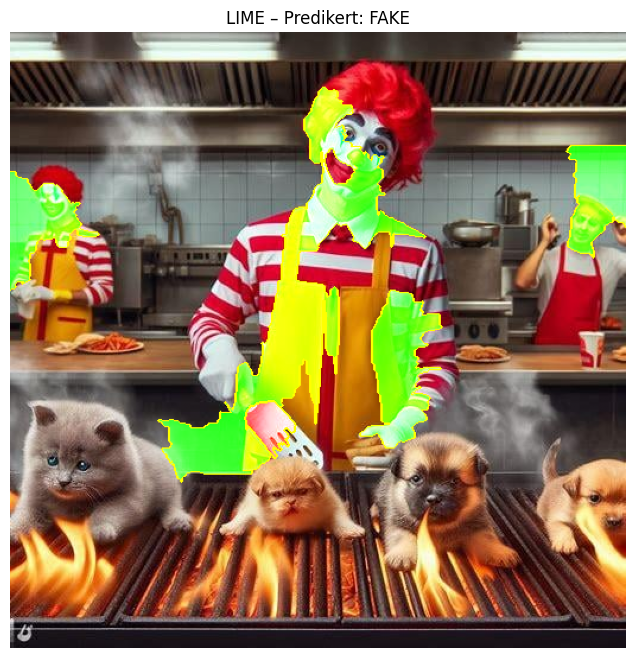

In [10]:
generate_lime("/content/fake_vs_real/test/fake/1855.jpg", clip_model, clip_transform, class_names)


📊 Modellen predikerer at bildet er: FAKE (klasse 0)


  0%|          | 0/1000 [00:00<?, ?it/s]

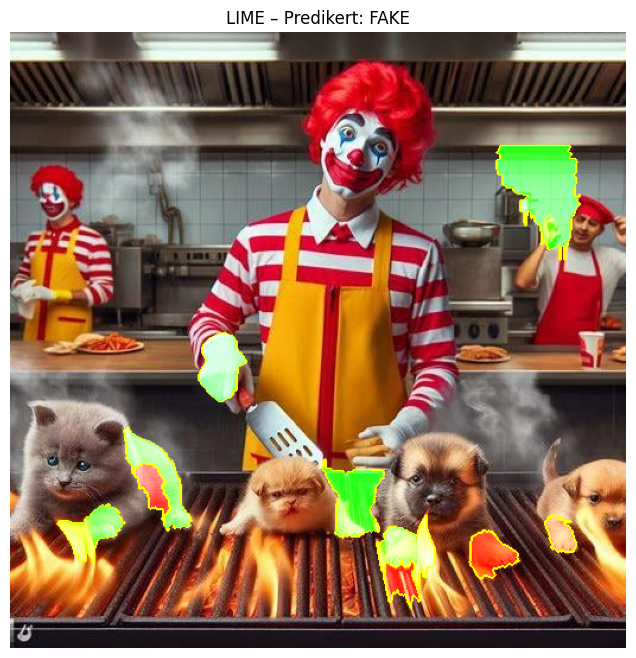

In [11]:
generate_lime("/content/fake_vs_real/test/fake/1855.jpg", resnet_model, resnet_transform, class_names)


In [12]:
generate_lime("/content/fake_vs_real/test/real/195.jpg", resnet_model, resnet_transform, class_names)



📊 Modellen predikerer at bildet er: REAL (klasse 1)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
generate_lime("/content/fake_vs_real/test/real/285.jpg", resnet_model, resnet_transform, class_names)
